# **Churn Prediction 'Die ZEIT'**

### **Used Libraries**

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import functions_data_handling as mld

# Library for timing
from time import time

# Ignore warnings while plotting
import warnings
warnings.filterwarnings("ignore")

# Feature Engineering & Selection modules
from sklearn.preprocessing import MinMaxScaler, StandardScaler
#from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# SUPERVISED LEARNING
# Libraries for classification issues
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# Libraries for classification and regression issues
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier

# Libraries for splitting data, hyperparameter tuning & Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

# Librarie for data balancing
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN

# Libraries for model evaluation
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_score, recall_score, roc_auc_score, roc_curve, f1_score, precision_recall_curve
from sklearn.metrics import fbeta_score, accuracy_score, make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
'''
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, Flatten
from keras.callbacks import TensorBoard
from keras.metrics import Recall, Precision

import tensorflow as tf
from tensorflow.keras import layers, regularizers'''

# Display the whole content of the data frame
pd.set_option('display.max_columns', None)   # Displays all columns
pd.set_option('display.max_rows', None)      # Displays all rows

# Define decimal places shown in the notebook
pd.options.display.float_format = '{:,.3f}'.format
from scipy.stats import uniform
# Visualization
%matplotlib inline
sns.set_style('whitegrid')

### **Read Data**

In [3]:
df = pd.read_csv("00_data/f_chtr_churn_traintable_nf.csv")

In [5]:
df = mld.data_cleaning(df)

In [ ]:
# Numeric and categorical features
shape_init_rows = df.shape[0]
shape_init_cols = df.shape[1]

print('The shape of the data set: {0} rows, {1} columns'.format(shape_init_rows, shape_init_cols))
print('   ')

cont_f = df.select_dtypes(include=['float64', 'int64'])
print('The number of numeric features: {0}'.format(len(cont_f.columns)))

cat_f = df.select_dtypes(include="object")
print('The number of objectlike features: {0}'.format(len(cat_f.columns)))

The shape of the data set: 156428 rows, 72 columns
   
The number of numeric features: 59
The number of objectlike features: 13


Here, new features are introduced, dummies are created and correlated features are dropped

In [6]:
df = mld.feature_engineering(df)

openrate_bestandskunden_3m | opened_anzahl_bestandskunden_6m | 0.88
clickrate_bestandskunden_3m | clicked_anzahl_bestandskunden_6m | 0.88
opened_anzahl_produktnews_6m | received_anzahl_produktnews_6m | 0.78
openrate_produktnews_3m | opened_anzahl_produktnews_6m | 0.76
clickrate_produktnews_3m | clicked_anzahl_produktnews_6m | 0.77
received_anzahl_hamburg_6m | nl_zeitverlag_hamburg | 0.92
opened_anzahl_hamburg_6m | received_anzahl_hamburg_6m | 0.7
openrate_hamburg_3m | opened_anzahl_hamburg_6m | 0.99
openrate_zeitbrief_3m | opened_anzahl_zeitbrief_6m | 0.96
cnt_dkey_more_than_one | more_than_one_cnt_abo | 0.74
{'clickrate_bestandskunden_3m', 'opened_anzahl_hamburg_6m', 'opened_anzahl_produktnews_6m', 'cnt_dkey_more_than_one', 'openrate_produktnews_3m', 'received_anzahl_hamburg_6m', 'openrate_zeitbrief_3m', 'clickrate_produktnews_3m', 'openrate_hamburg_3m', 'openrate_bestandskunden_3m'}


In [7]:
df.shape

(156428, 886)

## **2 - Modeling**
### **Data Selection**
+ y = Target variable -->>. ```churn```
+ X = Predictors -->> ```remaining columns```

In [ ]:
X = df.drop('churn',axis=1)
y = df['churn']

In [ ]:
print('The target variable (y) has {0} rows.'.format(y.shape[0]))
print('   ')
print('The predictor variables (X) have {0} rows and {1} columns.'.format(X.shape[0], X.shape[1]))

The target variable (y) has 156428 rows.
   
The predictor variables (X) have 156428 rows and 885 columns.


### **Train-Test-Split**

In [ ]:
# Splitting the data 
test_size = 0.3
RSEED = 42

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state = RSEED)

In [ ]:
type(X_train)

pandas.core.frame.DataFrame

## Scaling the numeric features

In [ ]:
numeric_features = ['vertragsdauer',
 'shop_kauf',
 "nl_aktivitaet",                   
 'received_anzahl_6m',
 'clicked_anzahl_6m',
 'unsubscribed_anzahl_6m',
 'openrate_3m',
 'clickrate_3m',
 'received_anzahl_bestandskunden_6m',
 'clicked_anzahl_bestandskunden_6m',
 'unsubscribed_anzahl_bestandskunden_6m',
 'received_anzahl_produktnews_6m',
 'clicked_anzahl_produktnews_6m',
 'unsubscribed_anzahl_produktnews_6m',
 'clicked_anzahl_hamburg_6m',
 'unsubscribed_anzahl_hamburg_6m',
 'clickrate_hamburg_3m',
 'received_anzahl_zeitbrief_6m',
 'clicked_anzahl_zeitbrief_6m',
 'unsubscribed_anzahl_zeitbrief_6m',
 'clickrate_zeitbrief_3m']

In [ ]:
scaler = StandardScaler()

# if you scale every column, do scaler.fit_transform(X_train)
X_train_scaled = scaler.fit_transform(X_train[numeric_features])

# if you scale every column, do scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test[numeric_features])

# if you scale every column, you can skip this part
X_train_preprocessed = np.concatenate([X_train_scaled, X_train.drop(numeric_features, axis=1)], axis=1)
X_test_preprocessed = np.concatenate([X_test_scaled, X_test.drop(numeric_features, axis=1)], axis=1)

In [ ]:
ros=RandomOverSampler()
X_train_preprocessed_balanced, y_train_balanced = ros.fit_resample(X_train_preprocessed, y_train)

### Try out ANN

In [ ]:
BATCH_SIZE = 1024
STEPS_PER_EPOCH = 138495//BATCH_SIZE
STEPS_PER_EPOCH

135

#### Learning Rate Decay

In [ ]:
init_learning_rate = 0.001
epochs_per_decay = 100 
decay_rate = 1
LR_decay = False

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
  init_learning_rate,
  decay_steps=STEPS_PER_EPOCH*epochs_per_decay,
  decay_rate=decay_rate,
  staircase=False)

def get_optimizer():
    if LR_decay:
        return tf.keras.optimizers.Adam(lr_schedule)
    else: 
        return tf.keras.optimizers.Adam()

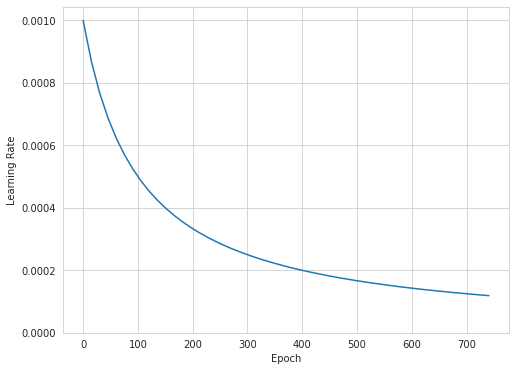

In [ ]:
step = np.linspace(0,100000)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/STEPS_PER_EPOCH, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

#### Define Metrics

In [ ]:
Recall = tf.keras.metrics.Recall(name='recall')
Precision = tf.keras.metrics.Precision(name='precision')
Loss = tf.keras.losses.BinaryCrossentropy(name='binary_crossentropy')

#### Early Stopping

In [ ]:
cb_recall = tf.keras.callbacks.EarlyStopping(monitor='recall', patience=100)
#cb_epoch_dots = tfdocs.modeling.EpochDots(report_every=10)

#### Gradient Check every n steps

In [ ]:
class ExtendedTensorBoard(keras.callbacks.TensorBoard):
    def _log_gradients(self, epoch):
        writer = self._get_writer(self._train_run_name)

        with writer.as_default(), tf.GradientTape() as g:
            # here we use test data to calculate the gradients
            features, y_true = list(val_dataset.batch(100).take(1))[0]

            y_pred = self.model(features)  # forward-propagation
            loss = self.model.compiled_loss(y_true=y_true, y_pred=y_pred)  # calculate loss
            gradients = g.gradient(loss, self.model.trainable_weights)  # back-propagation

            # In eager mode, grads does not have name, so we get names from model.trainable_weights
            for weights, grads in zip(self.model.trainable_weights, gradients):
                tf.summary.histogram(
                    weights.name.replace(':', '_') + '_grads', data=grads, step=epoch)

        writer.flush()

    def on_epoch_end(self, epoch, logs=None):
        # This function overwrites the on_epoch_end in tf.keras.callbacks.TensorBoard
        # but we do need to run the original on_epoch_end, so here we use the super function.
        super(ExtendedTensorBoard, self).on_epoch_end(epoch, logs=logs)

        if self.histogram_freq and epoch % self.histogram_freq == 0:
            self._log_gradients(epoch)

            
gradient_cb = ExtendedTensorBoard()

In [ ]:
model_under = tf.keras.Sequential([
layers.Dense(885*6, kernel_regularizer=regularizers.l1(l1=0.00001),
                 activation='relu', input_shape=(885,),
             kernel_initializer='he_normal'),
layers.Dropout(0.5),
layers.Dense(32, kernel_regularizer=regularizers.l1(l1=0.00001),
                 activation='relu',
             kernel_initializer='he_normal'),
layers.Dropout(0.5),
layers.Dense(32, kernel_regularizer=regularizers.l1(l1=0.00001),
                 activation='relu',
             kernel_initializer='he_normal'),
layers.Dropout(0.5),
layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_under.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 5310)              4704660   
_________________________________________________________________
dropout (Dropout)            (None, 5310)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                169952    
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 3

In [26]:
model_under.compile( optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001), 
                loss=Loss,
                metrics=[Loss, Recall, Precision,'accuracy'])
   
history_model_under = model_under.fit(X_train_preprocessed_balanced, y_train_balanced, validation_data=(X_test_preprocessed, y_test), epochs=500, batch_size=1024,verbose=1) 

Epoch 1/500
148/148 [==============================] - 3s 20ms/step - loss: 2.3712 - binary_crossentropy: 0.7157 - recall: 0.6304 - precision: 0.5517 - accuracy: 0.5591 - val_loss: 2.0930 - val_binary_crossentropy: 0.6490 - val_recall: 0.5253 - val_precision: 0.4939 - val_accuracy: 0.6891
Epoch 2/500
148/148 [==============================] - 2s 14ms/step - loss: 1.9074 - binary_crossentropy: 0.6462 - recall: 0.4964 - precision: 0.6701 - accuracy: 0.6260 - val_loss: 1.7145 - val_binary_crossentropy: 0.6264 - val_recall: 0.5688 - val_precision: 0.5178 - val_accuracy: 0.7051
Epoch 3/500
148/148 [==============================] - 2s 14ms/step - loss: 1.5764 - binary_crossentropy: 0.6316 - recall: 0.5165 - precision: 0.6935 - accuracy: 0.6441 - val_loss: 1.4215 - val_binary_crossentropy: 0.6107 - val_recall: 0.5406 - val_precision: 0.5565 - val_accuracy: 0.7268
Epoch 4/500
148/148 [==============================] - 2s 14ms/step - loss: 1.3216 - binary_crossentropy: 0.6193 - recall: 0.5258 

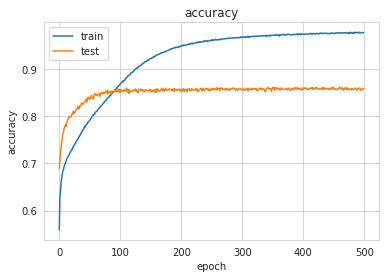

In [27]:
plt.plot(history_model_under.history['accuracy']) 
plt.plot(history_model_under.history['val_accuracy']) 
plt.title('accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

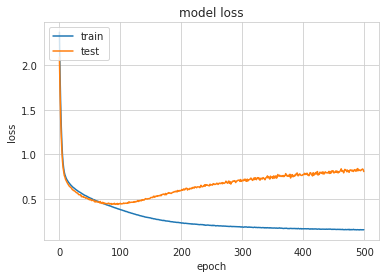

In [28]:
plt.plot(history_model_under.history['loss']) 
plt.plot(history_model_under.history['val_loss']) 
plt.title('model loss') 
plt.ylabel('loss')
plt.xlabel('epoch') 
plt.legend(['train', 'test'], loc='upper left') 
plt.show()

In [29]:
# Predicting the Test set results
y_pred_proba_under = model_under.predict(X_test_preprocessed)
#Converting probabilities into a binary result
y_pred_under = (y_pred_proba_under > 0.5)

In [30]:
# Making the Confusion Matrix
print(confusion_matrix(y_test, y_pred_under))
print(classification_report(y_test,y_pred_under))

[[30304  2224]
 [ 4436  9965]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.90     32528
           1       0.82      0.69      0.75     14401

    accuracy                           0.86     46929
   macro avg       0.84      0.81      0.83     46929
weighted avg       0.86      0.86      0.85     46929



In [31]:
results = model_under.evaluate(X_test_preprocessed, y_test)

1467/1467 [==============================] - 5s 3ms/step - loss: 0.8076 - binary_crossentropy: 0.7161 - recall: 0.6920 - precision: 0.8175 - accuracy: 0.8581


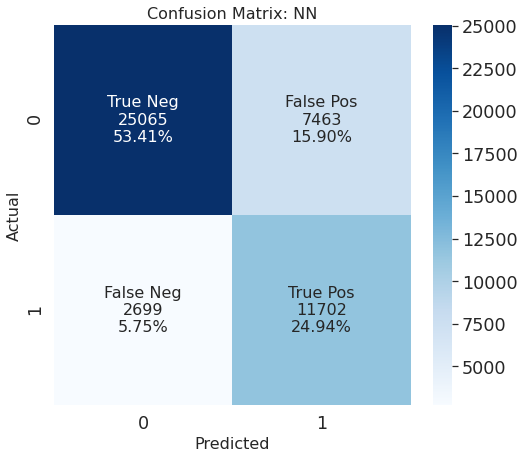

In [ ]:
import seaborn as sns
conf_matrix = confusion_matrix(y_test, y_pred_under)

group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ["{0:0.0f}".format(value) for value in
                conf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in
                     conf_matrix.flatten()/np.sum(conf_matrix)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.set(font_scale=1.6)
fig, ax = plt.subplots(figsize=(8,7)) 
sns.heatmap(conf_matrix, annot=labels, fmt='', cmap='Blues',annot_kws={"size": 16})
plt.title('Confusion Matrix: NN', fontsize = 16); # title with fontsize 20
plt.xlabel('Predicted', fontsize = 16);
plt.ylabel('Actual', fontsize = 16);
#plt.savefig('plots/confusion_matrix_NN_under.png',dpi=300)

In [36]:
y_pred_under2 = (y_pred_proba_under > 0.3)

In [37]:
# Making the Confusion Matrix
print(confusion_matrix(y_test, y_pred_under2))
print(classification_report(y_test,y_pred_under2))

[[29199  3329]
 [ 3954 10447]]
              precision    recall  f1-score   support

           0       0.88      0.90      0.89     32528
           1       0.76      0.73      0.74     14401

    accuracy                           0.84     46929
   macro avg       0.82      0.81      0.82     46929
weighted avg       0.84      0.84      0.84     46929

